In [190]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [191]:
# All states:
states = [
    "AL", "AK", "AZ", "AR", "CA", "CO", "CT", "DE", "FL", "GA",
    "HI", "ID", "IL", "IN", "IA", "KS", "KY", "LA", "ME", "MD",
    "MA", "MI", "MN", "MS", "MO", "MT", "NE", "NV", "NH", "NJ",
    "NM", "NY", "NC", "ND", "OH", "OK", "OR", "PA", "RI", "SC",
    "SD", "TN", "TX", "UT", "VT", "VA", "WA", "WV", "WI", "WY"
]
# States belonging to RGGI. Exclude VA here; it was only in RGGI for a short time
# Connecticut, Delaware, Maine, Maryland, Massachusetts, New Hampshire, New Jersey, New York, Pennsylvania, Rhode Island, and Vermont 
rggi_states = ["CT", "DE", "ME", "MD", "MA", "NH", "NJ", "NY", "PA", "RI", "VT"]
# States with cap-and-trade programs as well as AK and HI, which are of course outside the continental US.
other_states = ["CA", "AK", "HI"]
# States not belonging to RGGI or other cap-and-trade programs.
# WA will be included here because its cap-and-trade program was not around until after 2020.
control_states = list(set(states) - set(rggi_states) - set(other_states))

In [192]:
df = pd.read_csv(os.path.join("..", "..", "..", "SharedData", "total_state_data.csv"))
df.date = pd.to_datetime(df.date)
df = df[(df.date.dt.year>=1990)&(df.date.dt.year<2020)]
df.columns

Index(['state', 'state_sq_ft', 'year', 'month', 'date', 'monthly_population',
       'yearly_population', 'monthly_pop_density', 'yearly_pop_density',
       'monthly_emissions', 'prcp', 'snow', 'tavg', 'gdp_rel_2017',
       'gdp_rel_2017_interp', 'yearly_gdp_rel_2017', 'monthly_energy_prod',
       'yearly_energy_prod', 'monthly_energy_use', 'yearly_energy_use',
       'monthly_energy_flow', 'yearly_energy_flow', 'monthly_num_plants',
       'yearly_num_plants', 'total_facility_age', 'monthly_energy_total',
       'yearly_energy_total', 'monthly_energy_renew', 'yearly_energy_renew',
       'monthly_renew_pct', 'yearly_renew_pct', 'monthly_energy_fossil',
       'yearly_energy_fossil', 'monthly_fossil_pct', 'yearly_fossil_pct',
       'republican_vote_pct'],
      dtype='object')

In [193]:
de_emissions = df[df.state == 'DE'][['date', 'monthly_emissions', 'monthly_population']]

In [194]:
de_emissions['co2_per_capita']=de_emissions[5:]['monthly_emissions'] / de_emissions[5:]['monthly_population']

Text(0.5, 0, 'Year')

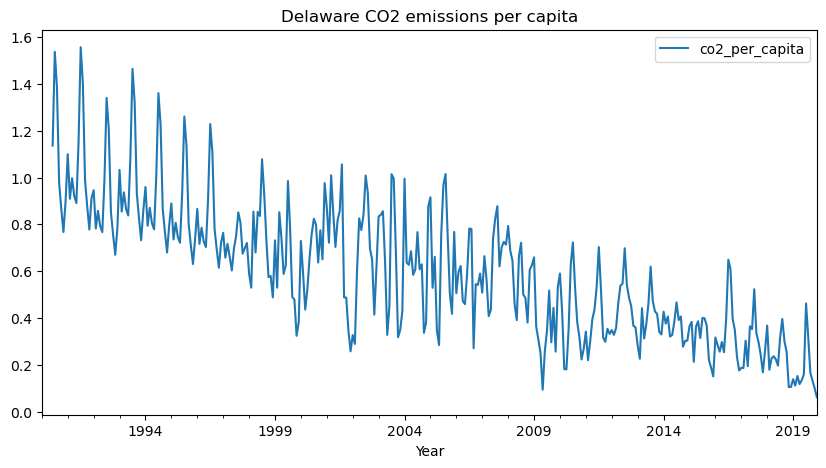

In [195]:
de_emissions.plot(x='date', y='co2_per_capita', title='Delaware CO2 emissions per capita', figsize=(10, 5))
plt.xlabel('Year')

We can clearly see that these data have a downward trend, which indicates that our time series is not stationary.

In [196]:
from sklearn.linear_model import LinearRegression

In [197]:
de_emissions.reset_index(drop=True, inplace=True)
de_emissions = de_emissions.drop(axis=0, index=range(0,5))
de_emissions['date_numeric']=de_emissions['date'].apply(pd.Timestamp.toordinal)

In [198]:
lm = LinearRegression()
lm.fit(de_emissions[['date_numeric']], de_emissions[['co2_per_capita']])

LinearRegression()

In [199]:
# Predict using the numeric date column
de_emissions['preds']=lm.predict(de_emissions[['date_numeric']])

# Get residuals
de_emissions['residuals'] = de_emissions['co2_per_capita'] - de_emissions['preds']

In [200]:
de_emissions

,date,monthly_emissions,monthly_population,co2_per_capita,date_numeric,preds,residuals
5,1990-06-01,7.607897e+05,669567.000000,1.136241,726619,0.995122,0.141119
6,1990-07-01,1.031065e+06,670693.083333,1.537313,726649,0.992917,0.544396
7,1990-08-01,9.306430e+05,671819.166667,1.385258,726680,0.990638,0.394620
8,1990-09-01,6.575320e+05,672945.250000,0.977096,726711,0.988359,-0.011263
9,1990-10-01,5.840857e+05,674071.333333,0.866504,726741,0.986153,-0.119649
...,...,...,...,...,...,...,...
355,2019-08-01,3.133598e+05,981340.000000,0.319318,737272,0.211917,0.107401
356,2019-09-01,1.611924e+05,981340.000000,0.164257,737303,0.209638,-0.045380
357,2019-10-01,1.285966e+05,981340.000000,0.131042,737333,0.207432,-0.076390
358,2019-11-01,9.734935e+04,981340.000000,0.099200,737364,0.205153,-0.105953


<Axes: title={'center': 'Delaware CO2 emissions per capita residuals'}, xlabel='date'>

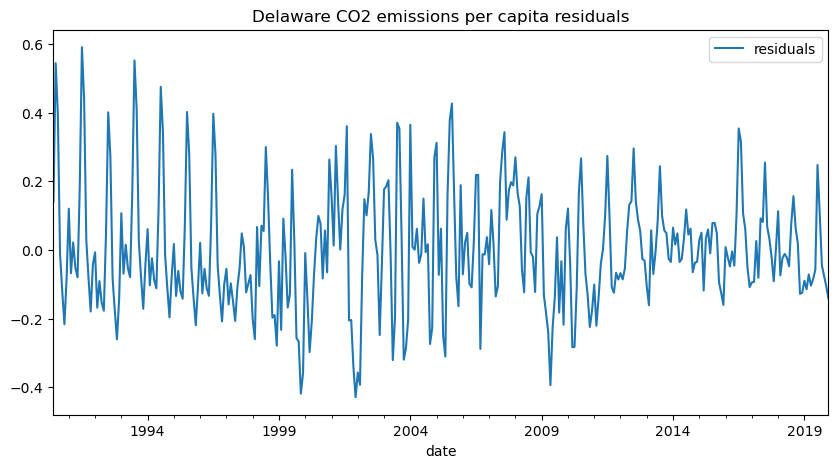

In [201]:
de_emissions.plot(x='date', y='residuals', title='Delaware CO2 emissions per capita residuals', figsize=(10, 5))

Now that we have de-trended the data, we take the differences in the residuals and check for difference stationarity:

In [202]:
de_emissions['resid_diffs']=de_emissions['residuals'].diff()

In [203]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

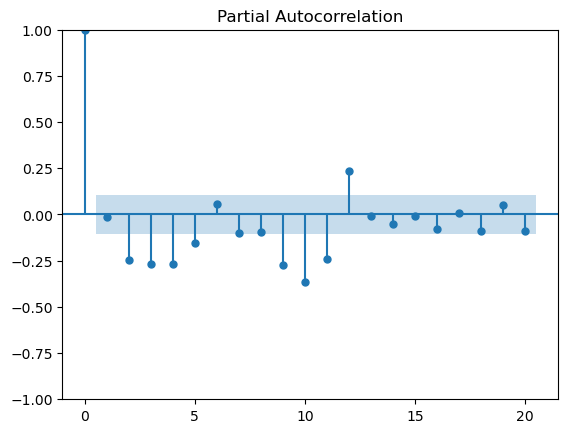

In [204]:
plot_pacf(de_emissions[1:]['resid_diffs'], lags=20)
plt.show()

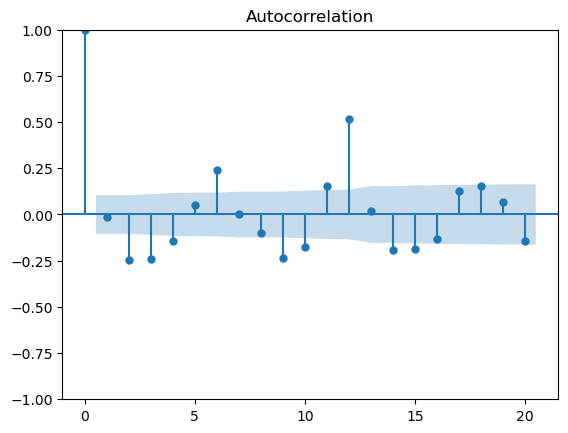

In [205]:
plot_acf(de_emissions[1:]['resid_diffs'], lags=20)
plt.show()

In [206]:
from statsmodels.tsa.stattools import adfuller

In [207]:
adfuller = adfuller(de_emissions[1:]['resid_diffs'], autolag='AIC')

In [208]:
print(f"The p-value from the Augmented Dickey-Fuller test is: {adfuller[1]}")

The p-value from the Augmented Dickey-Fuller test is: 1.833093904934757e-14


So we have strong evidence that from both the correlograms of the differenced residuals and the Augmented Dickey-Fuller test on the differenced residuals that this time-series is non-stationary. We now create an ARIMA model for the Delaware emissions data:

In [209]:
from pmdarima import auto_arima

In [210]:
auto_arima(de_emissions['co2_per_capita'], trace=True)

Performing stepwise search to minimize aic


/opt/anaconda3/envs/erdos_spring_2025/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/opt/anaconda3/envs/erdos_spring_2025/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/opt/anaconda3/envs/erdos_spring_2025/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/opt/anaconda3/envs/erdos_spring_2025/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/opt/anaconda3/envs/erdos_spring_2025/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarni

 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=-359.063, Time=0.47 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-243.882, Time=0.06 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-241.951, Time=0.04 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=-242.026, Time=0.07 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-245.769, Time=0.02 sec


/opt/anaconda3/envs/erdos_spring_2025/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/opt/anaconda3/envs/erdos_spring_2025/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/opt/anaconda3/envs/erdos_spring_2025/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/opt/anaconda3/envs/erdos_spring_2025/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/opt/anaconda3/envs/erdos_spring_2025/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarni

 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.54 sec


/opt/anaconda3/envs/erdos_spring_2025/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.42 sec


/opt/anaconda3/envs/erdos_spring_2025/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(3,1,2)(0,0,0)[0] intercept   : AIC=-357.239, Time=0.45 sec


/opt/anaconda3/envs/erdos_spring_2025/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(2,1,3)(0,0,0)[0] intercept   : AIC=-351.741, Time=0.50 sec


/opt/anaconda3/envs/erdos_spring_2025/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.39 sec


/opt/anaconda3/envs/erdos_spring_2025/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(1,1,3)(0,0,0)[0] intercept   : AIC=-349.489, Time=0.40 sec


/opt/anaconda3/envs/erdos_spring_2025/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(3,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.41 sec


/opt/anaconda3/envs/erdos_spring_2025/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(3,1,3)(0,0,0)[0] intercept   : AIC=-352.663, Time=0.61 sec
 ARIMA(2,1,2)(0,0,0)[0]             : AIC=-346.881, Time=0.18 sec

Best model:  ARIMA(2,1,2)(0,0,0)[0] intercept
Total fit time: 4.569 seconds


/opt/anaconda3/envs/erdos_spring_2025/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


ARIMA(order=(2, 1, 2), scoring_args={}, suppress_warnings=True)

In [211]:
import statsmodels.tsa.api as sm

In [212]:
de_arima = sm.ARIMA(de_emissions['co2_per_capita'], order = (2, 1, 2)).fit()

In [213]:
de_arima.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:         co2_per_capita   No. Observations:                  355
Model:                 ARIMA(2, 1, 2)   Log Likelihood                 178.441
Date:                Fri, 11 Apr 2025   AIC                           -346.881
Time:                        16:11:46   BIC                           -327.535
Sample:                             0   HQIC                          -339.184
                                - 355                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.9115      0.151      6.042      0.000       0.616       1.207
ar.L2         -0.4408      0.091     -4.848      0.000      -0.619      -0.263
ma.L1         -1.1888      0.165     -7.199      0.000      -1.512      -0.865
ma.L2          0.2513      0.161      1.565      0.118      -0.063       0.566
sigma2         0.0213      0.002     13.551      0.000       0.018       0.024
===================================================================================
Ljung-Box (L1) (Q):                   0.38   Jarque-Bera (JB):                15.17
Prob(Q):                              0.54   Prob(JB):                         0.00
Heteroskedasticity (H):               0.37   Skew:                             0.41
Prob(H) (two-sided):                  0.00   Kurtosis:                         3.61
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

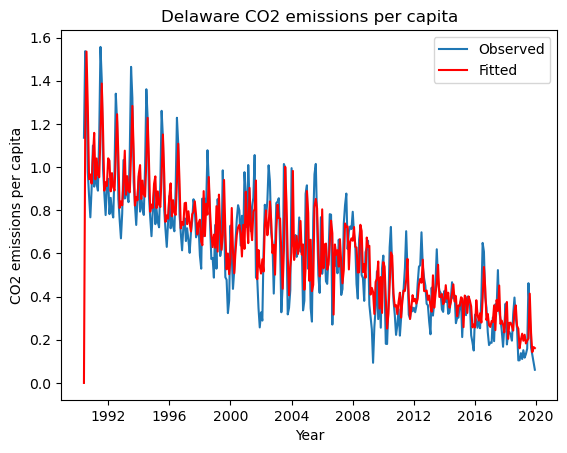

In [214]:
plt.plot(de_emissions['date'], de_emissions['co2_per_capita'], label='Observed')
plt.plot(de_emissions['date'], de_arima.fittedvalues, label='Fitted', color='red')
plt.title('Delaware CO2 emissions per capita')
plt.xlabel('Year')
plt.ylabel('CO2 emissions per capita')
plt.legend()

We now fit an ARIMA model on pre-2009 data: 

In [215]:
de_emissions_pre_RGGI = de_emissions[de_emissions['date'] < '2009-01-01'][['date', 'co2_per_capita']]

In [216]:
de_emissions_pre_RGGI

,date,co2_per_capita
5,1990-06-01,1.136241
6,1990-07-01,1.537313
7,1990-08-01,1.385258
8,1990-09-01,0.977096
9,1990-10-01,0.866504
...,...,...
223,2008-08-01,0.500218
224,2008-09-01,0.485350
225,2008-10-01,0.380222
226,2008-11-01,0.605658


In [217]:
auto_arima(de_emissions_pre_RGGI['co2_per_capita'], trace=True)

/opt/anaconda3/envs/erdos_spring_2025/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/opt/anaconda3/envs/erdos_spring_2025/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/opt/anaconda3/envs/erdos_spring_2025/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/opt/anaconda3/envs/erdos_spring_2025/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/opt/anaconda3/envs/erdos_spring_2025/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarni

Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=-159.988, Time=0.32 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-88.819, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-86.831, Time=0.03 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=-86.846, Time=0.05 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-90.789, Time=0.02 sec


/opt/anaconda3/envs/erdos_spring_2025/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/opt/anaconda3/envs/erdos_spring_2025/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/opt/anaconda3/envs/erdos_spring_2025/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/opt/anaconda3/envs/erdos_spring_2025/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/opt/anaconda3/envs/erdos_spring_2025/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarni

 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.30 sec


/opt/anaconda3/envs/erdos_spring_2025/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=-165.125, Time=0.26 sec


/opt/anaconda3/envs/erdos_spring_2025/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.25 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=-103.680, Time=0.07 sec


/opt/anaconda3/envs/erdos_spring_2025/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/opt/anaconda3/envs/erdos_spring_2025/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(3,1,1)(0,0,0)[0] intercept   : AIC=-164.477, Time=0.45 sec
 ARIMA(3,1,0)(0,0,0)[0] intercept   : AIC=-117.925, Time=0.10 sec


/opt/anaconda3/envs/erdos_spring_2025/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/opt/anaconda3/envs/erdos_spring_2025/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(3,1,2)(0,0,0)[0] intercept   : AIC=-161.577, Time=0.39 sec
 ARIMA(2,1,1)(0,0,0)[0]             : AIC=-160.545, Time=0.09 sec

Best model:  ARIMA(2,1,1)(0,0,0)[0] intercept
Total fit time: 2.344 seconds


/opt/anaconda3/envs/erdos_spring_2025/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


ARIMA(order=(2, 1, 1), scoring_args={}, suppress_warnings=True)

In [244]:
de_arima_pre_RGGI = sm.ARIMA(de_emissions_pre_RGGI['co2_per_capita'], order = (2, 1, 1), trend='t').fit()

/opt/anaconda3/envs/erdos_spring_2025/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)
/opt/anaconda3/envs/erdos_spring_2025/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)
/opt/anaconda3/envs/erdos_spring_2025/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)


In [245]:
fitted_vals=de_arima_pre_RGGI.fittedvalues

In [246]:
de_arima_pre_RGGI.forecast(8)

/opt/anaconda3/envs/erdos_spring_2025/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/opt/anaconda3/envs/erdos_spring_2025/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:837: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(


223    0.577519
224    0.537764
225    0.525875
226    0.529888
227    0.535151
228    0.535914
229    0.533259
230    0.529835
Name: predicted_mean, dtype: float64

/opt/anaconda3/envs/erdos_spring_2025/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(


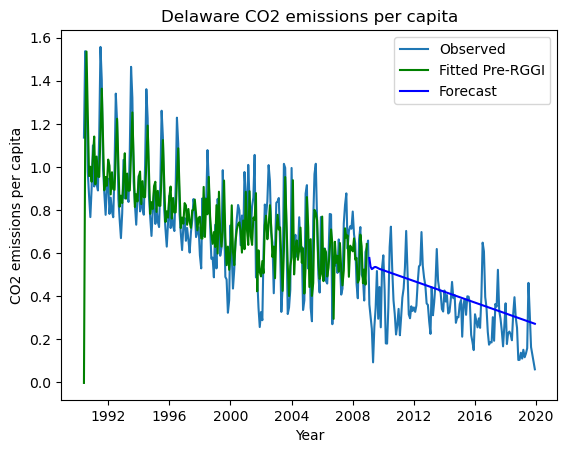

In [247]:
plt.plot(de_emissions['date'], de_emissions['co2_per_capita'], label='Observed')
#plt.plot(de_emissions['date'], de_arima.fittedvalues, label='Fitted', color='red')

plt.plot(de_emissions_pre_RGGI['date'], fitted_vals, label='Fitted Pre-RGGI', color='green')

# Generate forecast for the post-2009 period
forecast_start_idx = de_emissions[de_emissions['date'] > '2009-01-01'].index[0]
forecast_dates = de_emissions.loc[forecast_start_idx:, 'date']
forecast_values = de_arima_pre_RGGI.forecast(len(forecast_dates))

plt.plot(forecast_dates, forecast_values, label='Forecast', color='blue')
plt.title('Delaware CO2 emissions per capita')
plt.xlabel('Year')
plt.ylabel('CO2 emissions per capita')
plt.legend()

In [324]:
forecast_start_idx = de_emissions[de_emissions['date'] > '2008-12-01'].index[0]
forecast_dates = de_emissions.loc[forecast_start_idx:, 'date']
forecast_values = de_arima_pre_RGGI.forecast(len(forecast_dates))

/opt/anaconda3/envs/erdos_spring_2025/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/opt/anaconda3/envs/erdos_spring_2025/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:837: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(


In [326]:
forecast_dates

228   2009-01-01
229   2009-02-01
230   2009-03-01
231   2009-04-01
232   2009-05-01
         ...    
355   2019-08-01
356   2019-09-01
357   2019-10-01
358   2019-11-01
359   2019-12-01
Name: date, Length: 132, dtype: datetime64[ns]

In [327]:
from pmdarima.model_selection import train_test_split
train, test = train_test_split(de_emissions['co2_per_capita'], test_size=len(forecast_values))

In [328]:
de_arima_pre_RGGI_pmd = auto_arima(train, suppress_warnings=True, error_action='ignore')

/opt/anaconda3/envs/erdos_spring_2025/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/opt/anaconda3/envs/erdos_spring_2025/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/opt/anaconda3/envs/erdos_spring_2025/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/opt/anaconda3/envs/erdos_spring_2025/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/opt/anaconda3/envs/erdos_spring_2025/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarni

In [329]:
preds, conf_int = de_arima_pre_RGGI_pmd.predict(n_periods=len(test), return_conf_int=True)

/opt/anaconda3/envs/erdos_spring_2025/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/opt/anaconda3/envs/erdos_spring_2025/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:837: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(
/opt/anaconda3/envs/erdos_spring_2025/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/opt/anaconda3/envs/erdos_spring_2025/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


In [330]:
from sklearn.metrics import root_mean_squared_error
print("Test RMSE: %.3f" % (root_mean_squared_error(test, preds)))

Test RMSE: 0.144


Text(0.5, 0, 'Year')

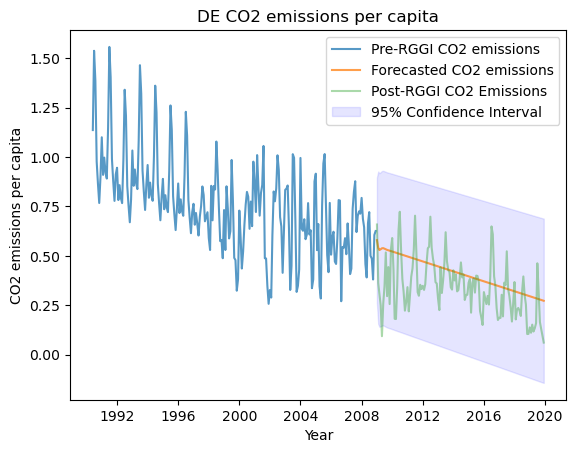

In [342]:
plt.plot(de_emissions.loc[de_emissions['date'] < '2009-01-01'].date, train, alpha=0.75, label='Pre-RGGI CO2 emissions')
plt.plot(de_emissions.loc[de_emissions['date'] >= '2009-01-01'].date, preds, alpha=0.75, label='Forecasted CO2 emissions')  # Forecasts
plt.plot(de_emissions.loc[de_emissions['date'] >= '2009-01-01'].date, test,
            alpha=0.4, label='Post-RGGI CO2 Emissions')  # Test data
plt.fill_between(de_emissions.loc[de_emissions['date'] >= '2009-01-01'].date,
                 conf_int[:, 0], conf_int[:, 1],
                 alpha=0.1, color='b', label='95% Confidence Interval')  # Prediction interval
plt.title("DE CO2 emissions per capita")
plt.legend(loc='upper right')
plt.ylabel("CO2 emissions per capita")
plt.xlabel("Year")

We now create a model-based bootstrap of the ARIMA model:

In [344]:
def model_bootstrap(train_data, test_data, n_bootstrap=100, order=(2,1,1)):
    """
    Simplified model-based bootstrap for an ARIMA time series forecast
    
    Parameters:
    -----------
    train_data : pd.Series
        Training data (assumed to be a pandas Series with datetime index)
    test_data : pd.Series
        Test data for comparison and evaluation
    n_bootstrap : int
        Number of bootstrap samples to generate
    order : tuple
        ARIMA order (p,d,q) - default is (2,1,1)
        
    Returns:
    --------
    dict containing:
        - bootstrap_forecasts: Array of bootstrapped forecasts
        - mean_forecast: Average of all bootstrap forecasts
        - lower_bound: Lower 95% confidence bound
        - upper_bound: Upper 95% confidence bound
        - original_forecast: Forecast from the original model
    """
    # 1. Fit the original ARIMA model to the training data
    de_arima_pre_RGGI_pmd = auto_arima(train, suppress_warnings=True, error_action='ignore')
    
    # Get the original forecast for comparison
    forecast_horizon = len(test_data)
    original_forecast = de_arima_pre_RGGI_pmd.predict(n_periods=forecast_horizon)
    
    # 2. Extract residuals from the model
    residuals = de_arima_pre_RGGI_pmd.resid().dropna()  # Remove NaN values that might occur at the beginning
    
    # 3. Initialize the array to store bootstrap forecasts
    bootstrap_forecasts = np.zeros((n_bootstrap, forecast_horizon))
    
    # 4. Perform bootstrap iterations
    for i in range(n_bootstrap):
        # Resample residuals with replacement
        boot_residuals = np.random.choice(residuals, size=len(residuals), replace=True)
        
        # Generate a new time series using the original model and bootstrapped residuals
        # Start with the original data
        history = train_data.copy()
        boot_series = []
        
        # Get model parameters
        ar_params=de_arima_pre_RGGI_pmd.arparams()  # AR parameters
        ma_params=de_arima_pre_RGGI_pmd.maparams()  # MA parameters
        
        if de_arima_pre_RGGI_pmd.with_intercept==True: 
            intercept=de_arima_pre_RGGI_pmd.params().iloc[0] 
        else: 
            intercept=0
                       
        # c. Fit a new model to the bootstrapped series
        # For simplicity, we'll skip generating the entire bootstrapped series
        # and just use the original model with bootstrapped residuals to generate forecasts
        
        # Initialize forecast array for this bootstrap sample
        boot_forecast = np.zeros(forecast_horizon)
        
        # Generate forecasts using the bootstrap method
        # Start with the original model's forecast
        boot_forecast = original_forecast.values.copy()
        
        # Add bootstrapped noise to each forecast point
        # Scale the residuals by forecast horizon (increasing uncertainty)
        for j in range(forecast_horizon):
            # Scale factor increases with the horizon to represent growing uncertainty
            scale_factor = 1.0 + (j * 0.01)  # Adjust this formula as needed
            boot_forecast[j] += np.random.choice(residuals) * scale_factor
        
        # Store this bootstrap forecast
        bootstrap_forecasts[i, :] = boot_forecast
    
    # 5. Calculate forecast statistics
    mean_forecast = np.mean(bootstrap_forecasts, axis=0)
    lower_bound = np.percentile(bootstrap_forecasts, 2.5, axis=0)
    upper_bound = np.percentile(bootstrap_forecasts, 97.5, axis=0)
    
    # 6. Evaluate the forecast
    rmse = root_mean_squared_error(test_data, mean_forecast)
    print(f"RMSE: {rmse:.4f}")
    
    # Return results as a dictionary
    results = {
        'bootstrap_forecasts': bootstrap_forecasts,
        'mean_forecast': mean_forecast,
        'lower_bound': lower_bound,
        'upper_bound': upper_bound,
        'original_forecast': original_forecast,
        'rmse': rmse
    }

    return results

In [345]:
model_bootstrap(train, test, n_bootstrap=1000, order=(2,1,1))

/opt/anaconda3/envs/erdos_spring_2025/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/opt/anaconda3/envs/erdos_spring_2025/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/opt/anaconda3/envs/erdos_spring_2025/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/opt/anaconda3/envs/erdos_spring_2025/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/opt/anaconda3/envs/erdos_spring_2025/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarni

RMSE: 0.1441


{'bootstrap_forecasts': array([[ 0.59508141,  0.65564163,  0.61563436, ..., -0.06672248,
          0.53385187, -0.2275254 ],
        [ 0.41617736,  0.47578164,  0.45251768, ..., -0.05053621,
          0.32302368,  0.02676377],
        [ 0.66779763,  0.52930003,  0.94388913, ...,  0.0538199 ,
         -0.05406093,  0.65637442],
        ...,
        [ 0.58063099,  0.38943329,  0.72481005, ...,  0.24318274,
          1.1052477 ,  0.15456626],
        [ 0.76197146,  0.55393315,  0.53416123, ...,  0.74541846,
          0.42086067,  0.28712737],
        [ 0.28830858,  0.70122914,  0.25082496, ...,  0.45322638,
          0.52293678, -0.05988956]]),
 'mean_forecast': array([0.57772533, 0.54383601, 0.5210832 , 0.5263956 , 0.53323138,
        0.53669843, 0.53753606, 0.53752639, 0.53033991, 0.51624143,
        0.52501064, 0.52812017, 0.50982726, 0.50909051, 0.51821666,
        0.50739168, 0.51352949, 0.50710467, 0.5212577 , 0.5084841 ,
        0.50902879, 0.50102125, 0.50634363, 0.50489142, 0.496

In [358]:
def plot_bootstrap_results(train, test, results):
    plt.figure(figsize=(12, 6))
    
    # Plot training and test data
    plt.plot(train.index, train, 'b-', label='Training Data')
    plt.plot(test.index, test, 'k-', label='Actual Test Data')
    
    # Plot forecasts
    plt.plot(test.index, results['mean_forecast'], 'r-', label='Mean Bootstrap Forecast')
    plt.plot(test.index, results['original_forecast'], 'g--', label='Original Forecast')
    
    # Plot confidence intervals
    plt.fill_between(test.index,
                     results['lower_bound'], 
                     results['upper_bound'], 
                     color='red', alpha=0.2, 
                     label='95% Bootstrap CI')
    
    # Plot a sample of bootstrap forecasts
    for i in range(0, 1000, 20):  # Plot every 10th forecast
        if i < len(results['bootstrap_forecasts']):
            plt.plot(test.index, results['bootstrap_forecasts'][i], 'gray', alpha=0.05)
    
    plt.title('Time Series Forecast with Model-Based Bootstrap')
    plt.xlabel('Date')
    plt.ylabel('CO2 Per Capita')
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

/opt/anaconda3/envs/erdos_spring_2025/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/opt/anaconda3/envs/erdos_spring_2025/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/opt/anaconda3/envs/erdos_spring_2025/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/opt/anaconda3/envs/erdos_spring_2025/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/opt/anaconda3/envs/erdos_spring_2025/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarni

RMSE: 0.1448


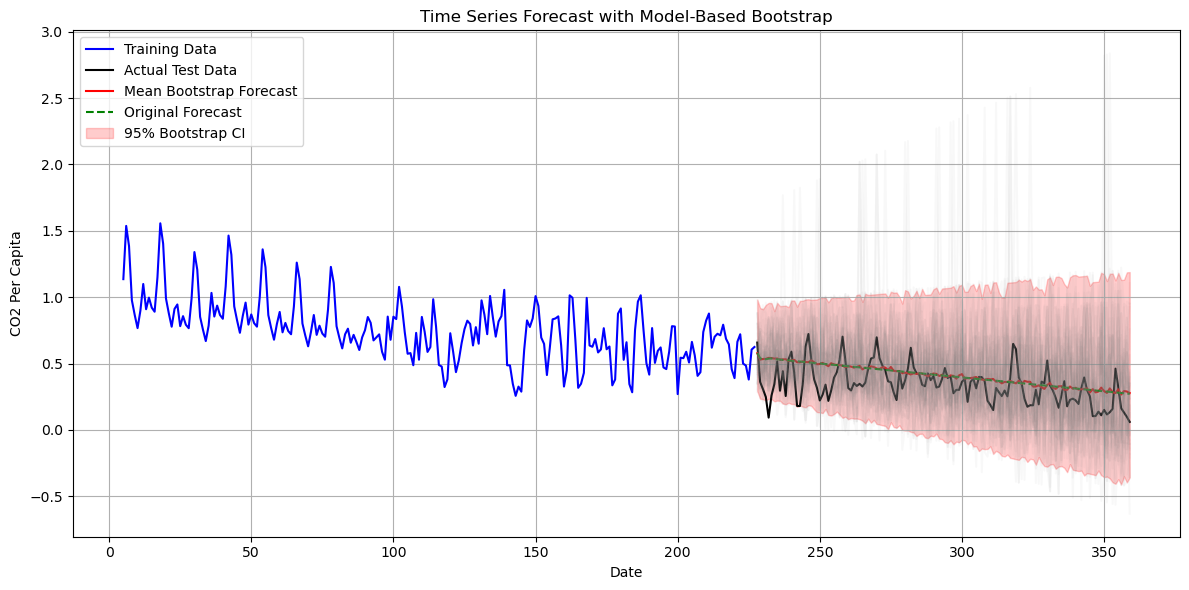

In [359]:
bootstrap_results = model_bootstrap(train, test, n_bootstrap=1000, order=(2,1,1))
plot_bootstrap_results(train, test, bootstrap_results)
# This code is a simplified model-based bootstrap for time series forecasting.